<a href="https://colab.research.google.com/github/isaacyeSN/SS2021/blob/main/Day1AM/Copy_of_SS21_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Linear Regression (Multi-variable)**

**1) Linear model**

## 0. Import necessary modules


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import mean_absolute_error
import argparse
import time

## 1. Data preparation

Preparing data for linear regression. Data made of combining $sin(x)$ and $log(x)$ with some random error  

$$y = \ 2 sin(x_1) + log({1 \over 2}x_2^2) + e$$  
$$ e \sim \mathcal{N} (0, 0.5) $$

As shown in the equation above, $sin(x)$ and $log(x)$ has different input $x_1$ and $x_2$ to have the output $y$. Therefore, the dataset we have has two input features for one $y$ value which requires **multivariable linear regression**.

---
The function generates total 2400 data and it is split into three parts; training, validation and testing. Each dataset has 1600, 400 and 400 respectively.

**Data Set**  
$$X_{train} \in \mathcal{R}^{1600 \times 2}, Y_{train} \in \mathcal{R}^{1600}$$  
$$X_{val} \in \mathcal{R}^{400 \times 2}, Y_{val} \in \mathcal{R}^{400}$$  
$$X_{test} \in \mathcal{R}^{400 \times 2}, Y_{test} \in \mathcal{R}^{400}$$

### Inspecting dataset

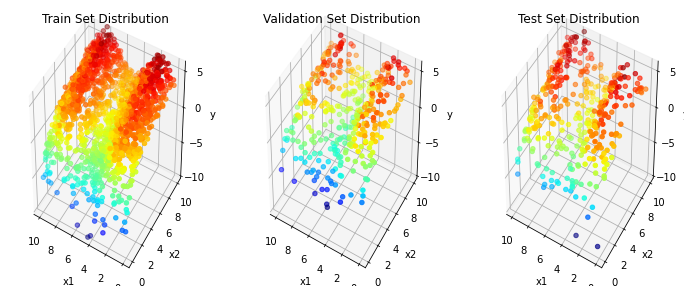

In [7]:
# ====== Data generation using Numpy ====== #
num_data = 2400
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10

e = np.random.normal(0, 0.5, num_data)

X = np.array([x1, x2]).T
y = 2*np.sin(x1) + np.log(0.5*x2**2) + e

# ====== Split Dataset ====== #

train_X, train_y = X[:1600, :], y[:1600]
val_X, val_y = X[1600:2000, :], y[1600:2000]
test_X, test_y = X[2000:, :], y[2000:]

# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(train_X[:, 0], train_X[:, 1], train_y, c=train_y, cmap='jet')

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
ax1.set_title('Train Set Distribution')
ax1.set_zlim(-10, 6)
ax1.view_init(40, -60)
ax1.invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(val_X[:, 0], val_X[:, 1], val_y, c=val_y, cmap='jet')

ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')
ax2.set_title('Validation Set Distribution')
ax2.set_zlim(-10, 6)
ax2.view_init(40, -60)
ax2.invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')

ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('y')
ax3.set_title('Test Set Distribution')
ax3.set_zlim(-10, 6)
ax3.view_init(40, -60)
ax3.invert_xaxis()

plt.show()

## 2. Model define  

Linear model is defined as $H(x) = Wx + b$ by calling `nn.Linear` module in PyTorch.

### **Linear Model**   
$$H = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 1}, b \in \mathcal{R}^{1}, H \in \mathcal{R}^{N \times 1})$$


In [10]:
# ===== Linear model ===== #
class LinearModel(nn.Module):
    def __init__(self, in_dim, out_dim):
      super(LinearModel, self).__init__()
      self.in_dim = in_dim
      self.out_dim = out_dim
      self.linear = nn.Linear(in_features = in_dim, out_features=out_dim, bias=True)

    def forward(self, x):
      return self.linear(x)

## 3. Simulation Define

`pytorch` has a function named `loss.backward()` to calculate parameter gradients and then `optimizer.step()` can update all parameters using those gradient.

For every a certain amount of iteration, Test Set is tested by comparing the predicted value with true value using Mean Absolute Error. 

$$MAE(Y_{true}, Y_{predict}) = \sum_{i} | \ y_{true}^{(i)} - y_{predict}^{(i)} \ | $$

In [31]:
def experiment(args):

    # ===== call the model ===== #

    model = LinearModel(args.in_dim, args.out_dim)

    print(model)
    print(model.linear.weight)
    print(model.linear.bias)

    # ====== Loss function ====== #
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=args.lr)

    # ====== Data collection ====== #
    list_epoch=[]
    list_train_loss=[]
    list_val_loss=[]
    list_acc = []
    list_acc_epoch = []

    # ====== Loop ====== #
    for epoch in range(args.epoch):  
        
        # ====== Train ====== #
        model.train()
        optimizer.zero_grad() # Initialize optimizer with zero gradient

        input_x = torch.Tensor(train_X)
        true_y = torch.Tensor(train_y)

        pred_y = model(input_x)

        loss = criterion(pred_y.squeeze(), true_y)
        loss.backward()
        optimizer.step()

        list_epoch.append(epoch)
        list_train_loss.append(loss.item())

        
        # ====== Validation ====== #
        model.eval()
        optimizer.zero_grad() # Initialize optimizer with zero gradient

        input_x = torch.Tensor(val_X)
        true_y = torch.Tensor(val_y)

        pred_y = model(input_x)

        loss = criterion(pred_y.squeeze(), true_y)
        list_val_loss.append(loss.item())


        # ====== Evaluation ======= #
        if epoch % 20 == 0: 
            
            # ====== Calculate Accuracy ====== #
            model.eval()
            optimizer.zero_grad() # Initialize optimizer with zero gradient

            input_x = torch.Tensor(test_X)

            pred_y = model(input_x).detach().numpy() # change it to Numpy array after dropping gradient

            acc = mean_absolute_error(test_y, pred_y)
            list_acc.append(acc)
            list_acc_epoch.append(epoch)


            # ====== True Y Scattering ====== #
            fig = plt.figure(figsize=(15,5))
           
            ax1 = fig.add_subplot(1, 3, 1, projection='3d')
            ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')
            
            ax1.set_xlabel('x1')
            ax1.set_ylabel('x2')
            ax1.set_zlabel('y')
            ax1.set_zlim(-10, 6)
            ax1.view_init(40, -40)
            ax1.set_title('True test y')
            ax1.invert_xaxis()

            # ====== Predicted Y Scattering ====== #
            ax2 = fig.add_subplot(1, 3, 2, projection='3d')
            ax2.scatter(test_X[:, 0], test_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

            ax2.set_xlabel('x1')
            ax2.set_ylabel('x2')
            ax2.set_zlabel('y')
            ax2.set_zlim(-10, 6)
            ax2.view_init(40, -40)
            ax2.set_title('Predicted test y')
            ax2.invert_xaxis()

            # ====== Just for Visualizaing with High Resolution ====== #
            input_x = torch.Tensor(train_X)
            pred_y = model(input_x).detach().numpy() 
            
            ax3 = fig.add_subplot(1, 3, 3, projection='3d')
            ax3.scatter(train_X[:, 0], train_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

            ax3.set_xlabel('x1')
            ax3.set_ylabel('x2')
            ax3.set_zlabel('y')
            ax3.set_zlim(-10, 6)
            ax3.view_init(40, -40)
            ax3.set_title('Predicted train y')
            ax3.invert_xaxis()
            
            plt.show()
            print(f'\n Epoch: {epoch}, loss: {loss.item():.4f}')

    return list_epoch, list_train_loss, list_val_loss, list_acc, list_acc_epoch

## 4. Train & Evaluation

LinearModel(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Parameter containing:
tensor([[-0.2883,  0.0234]], requires_grad=True)
Parameter containing:
tensor([-0.3512], requires_grad=True)


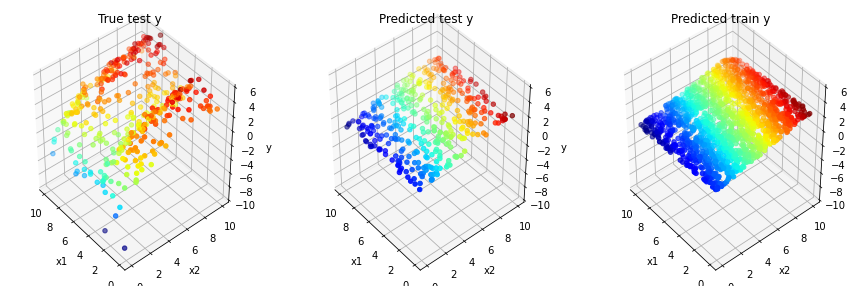


 Epoch: 0, loss: 5.4574


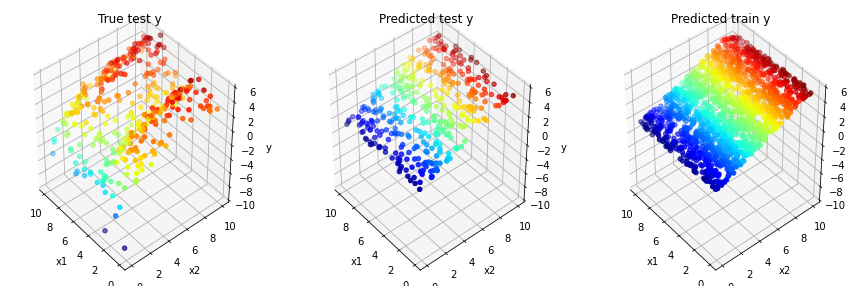


 Epoch: 20, loss: 2.6537


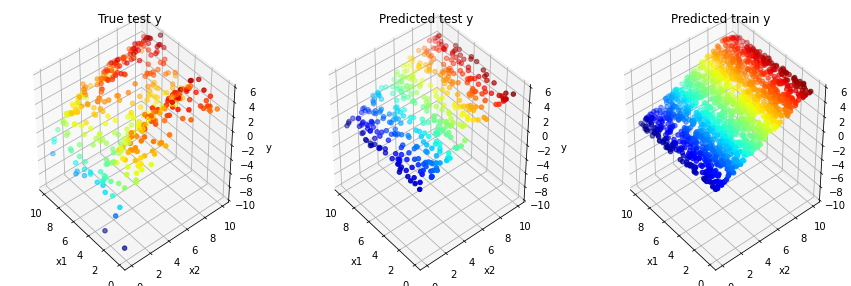


 Epoch: 40, loss: 2.6455


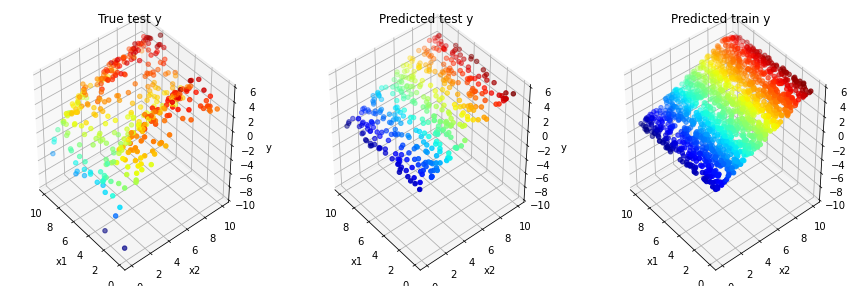


 Epoch: 60, loss: 2.6456


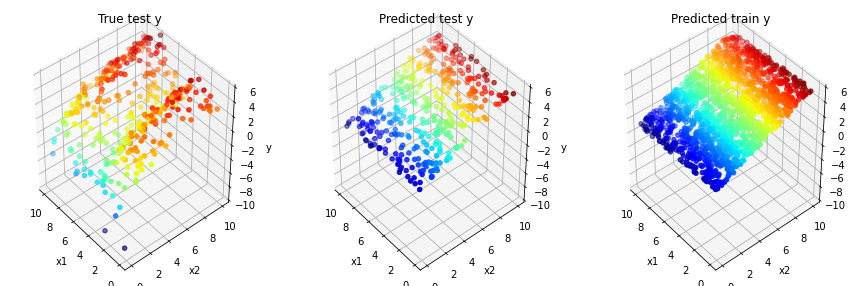


 Epoch: 80, loss: 2.6455


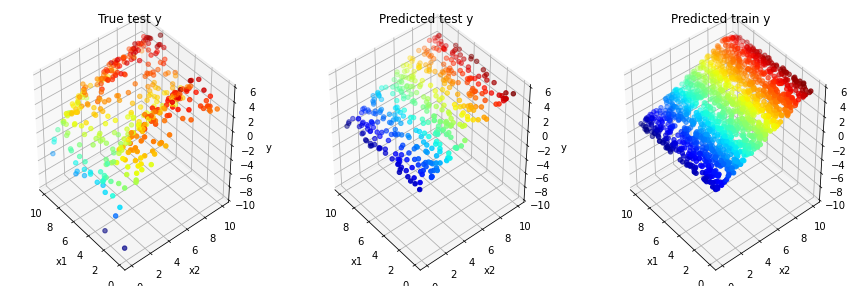


 Epoch: 100, loss: 2.6452


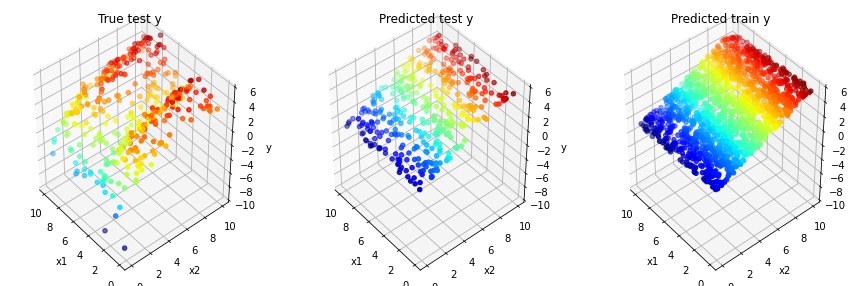


 Epoch: 120, loss: 2.6450


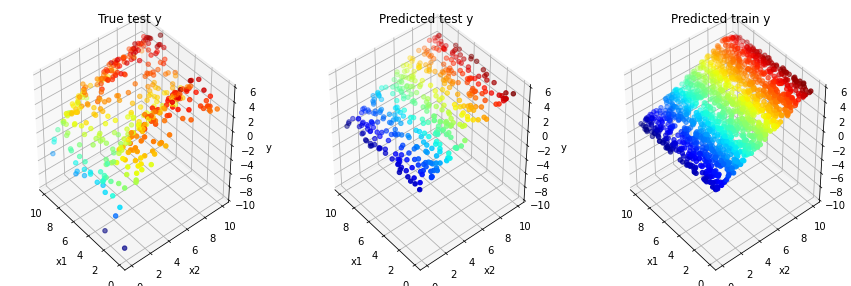


 Epoch: 140, loss: 2.6448


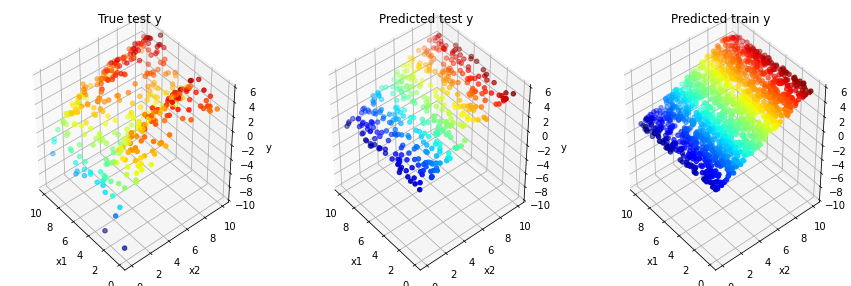


 Epoch: 160, loss: 2.6446


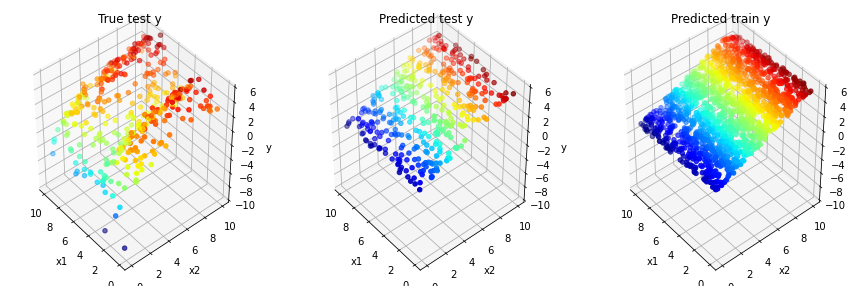


 Epoch: 180, loss: 2.6444

 Elapsed time: 5 sec


In [33]:
ts = time.time()

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

# ===== Set hyperparameters ===== #

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.in_dim = 2
args.out_dim = 1
args.lr = 0.005
args.epoch =200

list_epoch, list_train_loss, list_val_loss, list_acc, list_acc_epoch = experiment(args)

te = time.time()

print('\n Elapsed time: {} sec'.format(int(te-ts)))

## 5. Report  


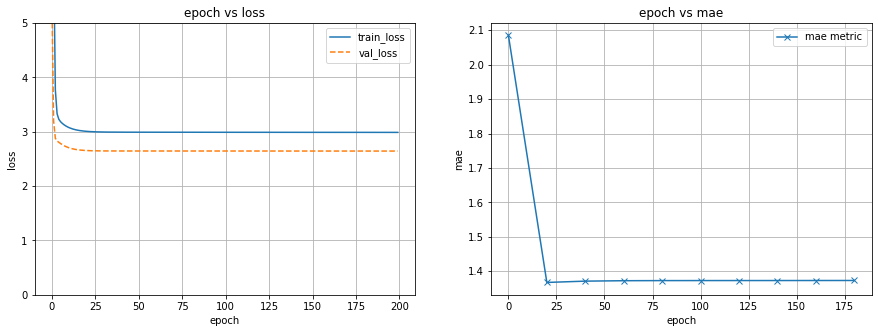

In [34]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='mae metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('mae')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs mae')


plt.show()